# Third Assignment
This is the third assignment of the course Self-Organizing Systems (2020/2021) at the Vienna University of Technology.

Sebastian Adam - 01525543

Fabio Oberweger - 01551139

# SOM Class Histogram Variants
In this notebook we build on the work of the GitHub repository https://github.com/smnishko/SOM-visualization, which contains functionality like
* training SOMs,
* plotting U-Matrices, Hit-Histograms or Component Planes on SOMs and
* reading in pre-trained SOMs in SOMLib File Format (http://www.ifs.tuwien.ac.at/dm/somtoolbox/somlibFileFormat.html).

We extend the mentioned repository with the functionality to plot SOM class histogram variants. The implemented SOM visualizations are **pie-charts** (as an overlay on any base coloring), **chessboard** and **attractor flooding visualizations**.

In the following we show the functionality of our code. Therefore, we create visualizations on differently sized SOMs based on the Chainlink and 10Cluster datasets. Moreover, we compare our visualizations with the visualizations of the SOMToolbox. The SOMToolbox is developed at the Institute of Software Technology and Interactive Systems at the Vienna University of Technology (http://www.ifs.tuwien.ac.at/dm/somtoolbox/). For this we also investigate the Boston-Housing and the Iris dataset in addition to the previously mentioned datasets. All datasets can be found on the SOMToolbox website (http://www.ifs.tuwien.ac.at/dm/somtoolbox/datasets.html).

In our explanations later on we will sometimes write that a unit u has instances or contains instances. By writing this we mean that for a set of instances there is no other unit v such that an instance has a smaller distance to v than to u.

The next cell contains the SOMToolBox_Parse class which allows to read in pre-trained SOMToolbox SOMs. However, in the original code by smnishko it is not possible to read in the class files. Hence, we added this functionality as our visualizations are based on classes.

In [62]:
import pandas as pd
import numpy as np
import gzip
from matplotlib.lines import Line2D


class SOMToolBox_Parse:
    
    def __init__(self, filename):
        self.filename = filename
    
    def read_weight_file(self,):
        df = pd.DataFrame()
        if self.filename[-3:len(self.filename)] == '.gz':
            with gzip.open(self.filename, 'rb') as file:
                df, vec_dim, xdim, ydim = self._read_vector_file_to_df(df, file)
        else:
            with open(self.filename, 'rb') as file:
                df, vec_dim, xdim, ydim = self._read_vector_file_to_df(df, file)

        file.close()            
        return df.astype('float64'), vec_dim, xdim, ydim



    def read_class_file(self,):
        df = pd.DataFrame()
        with open(self.filename, 'rb') as file:
            df, xdim, ydim, num_clas, clas_nam = self._read_class_file_to_df(df, file)

        file.close()
        return df.astype('int64'), xdim, ydim, num_clas, clas_nam


    def _read_vector_file_to_df(self, df, file):
        xdim, ydim, vec_dim, position = 0, 0, 0, 0
        for byte in file:
            line = byte.decode('UTF-8')
            if line.startswith('$'):
                xdim, ydim, vec_dim = self._parse_vector_file_metadata(line, xdim, ydim, vec_dim)
                if xdim > 0 and ydim > 0 and len(df.columns) == 0:
                    df = pd.DataFrame(index=range(0, ydim * xdim), columns=range(0, vec_dim))
            else:
                if len(df.columns) == 0 or vec_dim == 0:
                    raise ValueError('Weight file has no correct Dimensional information.')
                position = self._parse_weight_file_data(line, position, vec_dim, df)
        return df, vec_dim, xdim, ydim



    def _read_class_file_to_df(self, df, file):
        xdim, ydim, num_clas, clas_nam, position = 0, 0, 0, 0, 0
        for byte in file:
            line = byte.decode('UTF-8')
            if line.startswith('$'):
                xdim, ydim, num_clas, clas_nam = self._parse_class_file_metadata(line, xdim, ydim, num_clas, clas_nam)
                if xdim > 0 and ydim > 0 and len(df.columns) == 0:
                    df = pd.DataFrame(index=range(0, ydim), columns=['Class'])
            else:
                if len(df.columns) == 0:
                    raise ValueError('Class file has no correct Dimensional information.')
                position = self._parse_class_file_data(line, position, df)
        return df, xdim, ydim, num_clas, clas_nam


    def _parse_weight_file_data(self, line, position, vec_dim, df):
        splitted=line.split(' ')
        try:
            df.values[position] = list(np.array(splitted[0:vec_dim]).astype(float))
            position += 1
        except: raise ValueError('The input-vector file does not match its unit-dimension.') 
        return  position


    def _parse_class_file_data(self, line, position, df):
        splitted=line.split(' ')
        try:
            df.values[position] = list(np.array(splitted[1:2]).astype(int))
            position += 1
        except: raise ValueError('The input-vector file does not match its unit-dimension.')
        return  position


    def _parse_vector_file_metadata(self, line, xdim, ydim, vec_dim):
        splitted = line.split(' ')
        if splitted[0] == '$XDIM':      xdim = int(splitted[1])
        elif splitted[0] == '$YDIM':    ydim = int(splitted[1])
        elif splitted[0] == '$VEC_DIM': vec_dim = int(splitted[1])
        return xdim, ydim, vec_dim


    def _parse_class_file_metadata(self, line, xdim, ydim, num_clas, clas_nam):
        splitted = line.split(' ')
        if splitted[0] == '$XDIM':      xdim = int(splitted[1])
        elif splitted[0] == '$YDIM':    ydim = int(splitted[1])
        elif splitted[0] == '$NUM_CLASSES': num_clas = int(splitted[1])
        elif splitted[0] == '$CLASS_NAMES':
            splitted.pop(0)
            clas_nam = splitted
        return xdim, ydim, num_clas, clas_nam
        

In the following you can see helper functions that we need for our visualizations. We chose to explain the code with comments inside the code such that the explanations are closer to the relevant lines.

In [63]:
def dot(v,w):
    x,y = v
    X,Y = w
    return x*X + y*Y

def length(v):
    x,y = v
    return math.sqrt(x*x + y*y)

def vector(b,e):
    x,y = b
    X,Y = e
    return (X-x, Y-y)

def unit(v):
    x,y = v
    mag = length(v)
    return (x/mag, y/mag)

def distancee(p0,p1):
    return length(vector(p0,p1))

def scale(v,sc):
    x,y = v
    return (x * sc, y * sc)

def add(v,w):
    x,y = v
    X,Y = w
    return (x+X, y+Y)


# Given a line with coordinates 'start' and 'end' and the
# coordinates of a point 'pnt' the proc returns the shortest
# distance from pnt to the line and the coordinates of the
# nearest point on the line.
#
# 1  Convert the line segment to a vector ('line_vec').
# 2  Create a vector connecting start to pnt ('pnt_vec').
# 3  Find the length of the line vector ('line_len').
# 4  Convert line_vec to a unit vector ('line_unitvec').
# 5  Scale pnt_vec by line_len ('pnt_vec_scaled').
# 6  Get the dot product of line_unitvec and pnt_vec_scaled ('t').
# 7  Ensure t is in the range 0 to 1.
# 8  Use t to get the nearest location on the line to the end
#    of vector pnt_vec_scaled ('nearest').
# 9  Calculate the distance from nearest to pnt_vec_scaled.
# 10 Translate nearest back to the start/end line.

def pnt2line(pnt, start, end):
    line_vec = vector(start, end)
    pnt_vec = vector(start, pnt)
    line_len = length(line_vec)
    line_unitvec = unit(line_vec)
    pnt_vec_scaled = scale(pnt_vec, 1.0/line_len)
    t = dot(line_unitvec, pnt_vec_scaled)
    if t < 0.0:
        t = 0.0
    elif t > 1.0:
        t = 1.0
    nearest = scale(line_vec, t)
    dist = distancee(nearest, pnt_vec)
    nearest = add(nearest, start)
    return (dist, nearest)



def get_bounding_box(polygon):
    bounding = [1, 0, 1, 0]
    for p in polygon:
                if p[0] < bounding[0]:
                    bounding[0] = p[0]
                if p[0] > bounding[1]:
                    bounding[1] = p[0]
                if p[1] < bounding[2]:
                    bounding[2] = p[1]
                if p[1] > bounding[3]:
                    bounding[3] = p[1]
    for i in range(4):
                if bounding[i] > 1:
                    bounding[i] = 1
                if bounding[i] < 0:
                    bounding[i] = 0
                bounding[i] = round(bounding[i], 2)
    return bounding

We extended the SomViz class by functions that compute the pie-chart, chessboard and attractor flooding visualizations.

The **pie chart** implementation is straight forward. We just need to count for each unit how many instances of which class are closest to this unit and create a pie-chart accoringly.

Some more algorithmic geometry is needed for the **chessboard visualization**. We compute a voronoi tessellation based on the units. Then, we again find and count how many instances of which class are closest to each unit. Based on this information we color the polygon of each unit with the color of the dominant class for this unit. Finally, we color random pixels with the colors of the other occuring classes in a percentually correct way.

For the **attractor flooding visualization** we do the same steps as for the chessboard visualization until the point where we color the pixels. Instead of the last step, we compute an underlying graph where the nodes are the units and there is an edge between a unit and a unit of a neighboring polygon labelled with the color c if and only if both units are closest to instances that are assigned color c. There can only be edges between neighboring polygon. We created this graph by using the delaunay triangulation, which we needed to find these neighboring polygons. Finally, we used this created graph to compute the floodings.

**Please** see the code for a more detailed and precise explanation. As we have mentioned before, we tried to add comments in the code to make everything more understandable. For parts that are harder to understand, we added several lines of comments.

In [64]:
import numpy as np
from scipy.spatial import distance_matrix, distance
from ipywidgets import Layout, HBox, Box, widgets, interact
import plotly.graph_objects as go
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as mpatches
import math
import plotly.express as px
from IPython.display import display, Image


from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

class SomViz:
    
    def __init__(self, weights=[], m=None, n=None):
        self.weights = weights
        self.m = m
        self.n = n
        self.xs = 1.0 / n
        self.ys = 1.0 / m
        self.classes = None
        self.cnames = None
        self.ccolors = None
        self.vdiagram = None
        self.vpoints = None
        self.vclasses = None
        self.legend = None

    def addclasses(self, cdata=[], idata=[], cnum=0, cnam=[]):
        self.cnames = cnam
        self.ccolors = []
        self.legend = []
        self.classes = [0] * (self.m * self.n)
        for i in range(0, cnum):
            self.ccolors.append(px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)])
            self.legend.append(mpatches.Patch(color=px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)],
                                              label=cnam[i]))
        for i in range(0, len(self.classes)):
            self.classes[i] = [0] * cnum
        for i, v in enumerate(idata):
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            index = cdata[i]
            self.classes[position][index[0]] = self.classes[position][index[0]] + 1

    def compute_voronoi(self):
        # add dummy vertices so that plane is finite
        self.vpoints = [[-2, -2], [2, 2], [2, -2], [-2, 2]]
        self.vclasses = [len(self.classes[0]) * [0],
                   len(self.classes[0]) * [0],
                   len(self.classes[0]) * [0],
                   len(self.classes[0]) * [0]]
        # position becomes a vpoint if it has a non-empty class array
        for position, v in enumerate(self.classes):
            if sum(v) > 0:
                x,y = position % self.n, position // self.n
                x1 = self.xs * x + (self.xs / 2)
                y1 = self.ys * y + (self.ys / 2)
                self.vpoints.append([x1, y1])
                self.vclasses.append(v)
        # compute Voronoi tesselation
        self.vdiagram = Voronoi(self.vpoints)


    def show_legend(self, title='Legend'):
        plt.rcParams["figure.figsize"] = (0,0)
        plt.axis('off')
        plt.title(title)
        plt.legend(handles=self.legend, bbox_to_anchor=(0, 1), loc='upper left', ncol=8)
        plt.show()

    def piecharts(self, som_m=None, scale=False):
        # add a tiny pie chart that is not visible, just so that once all colors are set for the whole domain
        v = [1] * len(self.cnames)
        som_m.add_trace(go.Pie(labels=self.cnames, values=v, textinfo='none', domain={'x': [0, 0.000000000000000001], 'y': [0, 0.000000000000001]},
                                                   marker=dict(colors=self.ccolors)))
        # add all other pie charts according to their position
        for position, v in enumerate(self.classes):
            x,y = position % self.n, position // self.n
            x1 = self.xs * x
            x2 = self.xs * x + self.xs
            y1 = self.ys * y
            y2 = self.ys * y + self.ys
            if som_m!=None: som_m.add_trace(go.Pie(labels=self.cnames, scalegroup= 1 if scale else None,
                                                   values=v, textinfo='none', domain={'x': [x1, x2], 'y': [y1, y2]},
                                                   marker=dict(colors=px.colors.qualitative.Plotly)))
        som_m.update(layout_showlegend=False)
        width = 700
        height = 700
        if self.m > self.n:
            width = width / (self.m/self.n)
        elif self.m < self.n:
            height = height / (self.n/self.m)
        img_bytes = um.to_image(format="png", width=width, height=height)
        display(Image(img_bytes))


    def chess(self, pixel_size=0.005, title='Chess'):
        if self.m > self.n:
            plt.rcParams["figure.figsize"] = (4,4/(self.n/self.m))
        elif self.m < self.n:
            plt.rcParams["figure.figsize"] = (4/(self.m/self.n),4)
        else:
            plt.rcParams["figure.figsize"] = (4,4)
        # plot the voronoi diagram
        voronoi_plot_2d(self.vdiagram, show_vertices=False, show_points=False)
        # go over all voronoi cells
        for position in range(4, len(self.vpoints)):
            # get the current polygon
            polygon = [self.vdiagram.vertices[i] for i in self.vdiagram.regions[self.vdiagram.point_region[position]]]
            pclass = self.vclasses[position]
            # fill with the dominant color
            pdomin = pclass.index(max(pclass))
            plt.fill(*zip(*polygon), self.ccolors[pdomin])
            # if dominant color = only color go to next cell
            if pclass.count(0) == len(pclass) - 1:
                continue
            pclassprob = np.nan_to_num(np.array(pclass) / np.sum(np.array(pclass)))
            bounding = get_bounding_box(polygon)
            p = Path(polygon)
            s = np.power(pixel_size, 2)
            # go over all pixels within the bounding box
            for x in np.arange(bounding[0], bounding[1], pixel_size):
                for y in np.arange(bounding[2], bounding[3], pixel_size):
                    # check if the pixel is within the polygon
                    xpoint = x + s
                    ypoint = y + s
                    side = pixel_size - 2 * s
                    pixel_inside = p.contains_points([[xpoint, ypoint],
                                                       [xpoint + side, ypoint + side],
                                                       [xpoint, ypoint + side],
                                                       [xpoint + side, ypoint]])
                    # if the pixel is within the polygon randomly fill it with a class color
                    # (with probability distribution according to the class distribution in that cell)
                    if sum(pixel_inside) == 4:
                        pixel = [[x, y],
                                  [x + pixel_size, y],
                                  [x + pixel_size, y + pixel_size],
                                  [x, y + pixel_size]]
                        plt.fill(*zip(*pixel), self.ccolors[np.random.choice(range(len(self.classes[0])), p=pclassprob)])
        plt.xlim([0,1]), plt.ylim([0,1])
        plt.title(title)
        plt.show()

    def flood(self, pixel_size = 0.005, title='Flood'):
        if self.m > self.n:
            plt.rcParams["figure.figsize"] = (4,4/(self.n/self.m))
        elif self.m < self.n:
            plt.rcParams["figure.figsize"] = (4/(self.m/self.n),4)
        else:
            plt.rcParams["figure.figsize"] = (4,4)
        # save to every vpoint all neighbors that have a common edge
        neighbors_edge  = [[] for _ in range(len(self.vpoints))]
        # save all points at which two vcells meet and which cells meet at that point
        point_neighbors = []
        point_neighbors_point = []
        # position x position matrix that stores the the common points of position x and y
        neighbormatrix = [[[] for _ in range(len(self.vpoints))] for _ in range(len(self.vpoints))]
        # save all edges at which two vcells meet and which cells meet at that edge
        edge_neighbors = []
        edge_neighbors_edge = []

        # fill the point_neighbors list (cap points at 1 and 0)
        for position in range(4, len(self.vpoints)):
            for i in self.vdiagram.regions[self.vdiagram.point_region[position]]:
                x = self.vdiagram.vertices[i][0]
                y = self.vdiagram.vertices[i][1]
                if x > 1:
                    x = 1
                if x < 0:
                    x = 0
                if y > 1:
                    y = 1
                if y < 0:
                    y = 0
                vertex = (x, y)
                if vertex in point_neighbors:
                    index = point_neighbors.index(vertex)
                    point_neighbors_point[index].append(position)
                else:
                    point_neighbors.append(vertex)
                    point_neighbors_point.append([position])
        # fill the neighboring matrix
        for index, p in enumerate(point_neighbors_point):
            for i in p:
                for j in p:
                    if i != j:
                        neighbormatrix[i][j].append(point_neighbors[index])
        # fill the edge_neighbors list
        for i, p in enumerate(neighbormatrix):
            for j, px in enumerate(p):
                if len(px) == 2:
                    neighbors_edge[i].append(j) if j not in neighbors_edge[i] else neighbors_edge[i]
                    neighbors_edge[j].append(i) if i not in neighbors_edge[j] else neighbors_edge[j]
                    edge_neighbors.append([(px[0][0] + px[1][0]) / 2, (px[0][1] + px[1][1]) / 2])
                    edge_neighbors.append([(px[0][0] + px[1][0]) / 2, (px[0][1] + px[1][1]) / 2])
                    edge_neighbors_edge.append([i, j])
                    edge_neighbors_edge.append([j, i])
        # plot the voronoi diagram
        voronoi_plot_2d(self.vdiagram, show_vertices=False, show_points=False)
        # go over all voronoi cells
        for position in range(4, len(self.vpoints)):
            # get the current polygon
            polygon = [self.vdiagram.vertices[i] for i in self.vdiagram.regions[self.vdiagram.point_region[position]]]
            pclass = self.vclasses[position]
            pdomin = pclass.index(max(pclass))
            # fill with the dominant color
            plt.fill(*zip(*polygon), self.ccolors[pdomin])
            # if dominant color = only color go to next cell
            if pclass.count(0) == len(pclass) - 1:
                continue
            bounding = get_bounding_box(polygon)
            p = Path(polygon)
            pclassprobs = np.nan_to_num(np.array(pclass) / np.sum(np.array(pclass)))
            pattractors = [[] for _ in range(len(pclassprobs))]
            # for each class that is not the dominant class and not empty in this cell compute the attractos
            for i, pclassprob in enumerate(pclassprobs):
                if pclassprob > 0 and i != pdomin:
                    # find all edge neighbors that also feature the class
                    p_edge_neighbors = []
                    for neighbor in neighbors_edge[position]:
                        nclass = self.vclasses[neighbor]
                        if nclass[i] > 0:
                            p_edge_neighbors.append(neighbor)
                    # if there are no edge neighbors add the voronoi vertex as an attractor
                    if len(p_edge_neighbors) == 0:
                        pattractors[i].append([self.vpoints[position]])
                    # if there is exactly one edge neighbor add a line from the voronoi vertex to the mid
                    # point of that edge as an attractor
                    if len(p_edge_neighbors) == 1:
                        pattractors[i].append([self.vpoints[position],
                                               edge_neighbors[edge_neighbors_edge.index([position, p_edge_neighbors[0]])]])
                    # If there are more than one edge neighbors first compute all the ones that are isolated, i.e.
                    # if a edge neighbor n1 of the current position does not have another edge neighbor n2 that also
                    # features the searched class and also does not have a edge neighbor n2 that is only separated
                    # by 1 other shared edge neighbor n3 of n1 and n2 (that also features teh searched class) then the
                    # neighbor is isolated
                    if len(p_edge_neighbors) > 1:
                        isolated = []
                        for n1 in p_edge_neighbors:
                            none = True
                            for n2 in p_edge_neighbors:
                                if not none:
                                    break
                                if n1 != n2:
                                    if n2 in neighbors_edge[n1]:
                                        none = False
                                    n3s = [value for value in neighbors_edge[n1] if value in neighbors_edge[n2]]
                                    for n3 in n3s:
                                        if n3 != position and self.vclasses[n3][i] > 0:
                                            none = False
                            if none:
                                isolated.append(n1)
                        # for each isolated neighbor we add a line from the voronoi vertex to the mid point of
                        # that edge as an attractor
                        for n1 in isolated:
                            pattractors[i].append([self.vpoints[position],
                                                   edge_neighbors[edge_neighbors_edge.index([position, n1])]])
                        # For all edge neighbors n1 of the current position go over all edge neighbors n2
                        # of the current position and check:
                        # If n1 and n2 are also edge neighbors then check if there exists isolated neighbors
                        # - If yes: Add a line attractor from the voronoi vertex to the intersection point of n1, n2
                        # and the current position
                        # - If no: Only add the intersection point of n1, n2 and the current position as an attractor
                        # If n1 and n2 are not direct edge neighbors but they both share a common edge neighbor n3,
                        # that is not the current position and also has the searched class do the same as above
                        for n1 in p_edge_neighbors:
                            for n2 in p_edge_neighbors:
                                if n1 != n2:
                                    if n2 in neighbors_edge[n1]:
                                        for index, ni in enumerate(point_neighbors_point):
                                            if position in ni and n1 in ni and n2 in ni:
                                                nx = point_neighbors[index]
                                                if len(isolated) == 0:
                                                    pattractors[i].append([[nx[0], nx[1]]])
                                                else:
                                                    pattractors[i].append([self.vpoints[position], [nx[0], nx[1]]])
                                    else:
                                        n3s = [value for value in neighbors_edge[n1] if value in neighbors_edge[n2]]
                                        for n3 in n3s:
                                            if n3 != position and self.vclasses[n3][i] > 0:
                                                for index, ni in enumerate(point_neighbors_point):
                                                    if position in ni and n1 in ni and n2 in ni:
                                                        nx = point_neighbors[index]
                                                        if len(isolated) == 0:
                                                            pattractors[i].append([[nx[0], nx[1]]])
                                                        else:
                                                            pattractors[i].append([self.vpoints[position], [nx[0], nx[1]]])
                                                break
            pcube = [[] for _ in range(len(pclassprobs))]
            s = np.power(pixel_size, 2)
            # go over all pixels within the bounding box
            for x in np.arange(bounding[0], bounding[1], pixel_size):
                for y in np.arange(bounding[2], bounding[3], pixel_size):
                    # check if the pixel is within the polygon
                    xpoint = x + s
                    ypoint = y + s
                    side = pixel_size - 2 * s
                    pixel_inside = p.contains_points([[xpoint, ypoint],
                                                       [xpoint + side, ypoint + side],
                                                       [xpoint, ypoint + side],
                                                       [xpoint + side, ypoint]])
                    if sum(pixel_inside) == 4:
                        # if the pixel is within the polygon go over all classes and for each class over all its
                        # attractors. Calculate the minimum distance to each attractor and the add the polygon
                        # with the distance information list of all polygons for that class
                        for i, attraci in enumerate(pattractors):
                            dist = 1
                            for attrac in attraci:
                                mdist = 1
                                if len(attrac) == 1:
                                    XA = [(x + pixel_size / 2, y + pixel_size / 2)]
                                    XB = [(attrac[0][0], attrac[0][1])]
                                    mdist = distance.cdist(XA, XB, 'euclidean')
                                if len(attrac) == 2:
                                    px = [x + (pixel_size / 2), y + (pixel_size / 2)]
                                    p0 = [attrac[0][0], attrac[0][1]]
                                    p1 = [attrac[1][0], attrac[1][1]]
                                    mdist, nearest = pnt2line(px, p0, p1)
                                if mdist < dist:
                                    dist = mdist
                            pcube[i].append((dist, [[x, y],
                                      [x + pixel_size, y],
                                      [x + pixel_size, y + pixel_size],
                                      [x, y + pixel_size]])) if (dist, [[x, y],
                                      [x + pixel_size, y],
                                      [x + pixel_size, y + pixel_size],
                                      [x, y + pixel_size]]) not in pcube else pcube
            # sort the pixels according to the distance to their attractor
            for i in pcube:
                i.sort()
            # calculate how many pixels each class gets to have in that cell
            ppixels = []
            for pclassprob in pclassprobs:
                ppixels.append(math.ceil(len(pcube[0]) * pclassprob))
            # go over all classes and if it is not the dominant one, color the amount of pixels that this
            # class gets in order by the attractor sorted pixel array
            for i, ppixel in enumerate(ppixels):
                if i != pdomin:
                    for polyin in range(ppixel):
                        if polyin < len(pcube[i]):
                            plt.fill(*zip(*pcube[i][polyin][1]), self.ccolors[i])
        plt.xlim([0,1]), plt.ylim([0,1])
        plt.title(title)
        plt.show()


    def umatrix(self, som_map=None, color="Viridis", interp = "best", title=""):
        um =np.zeros((self.m *self.n, 1))
        neuron_locs = list()
        for i in range(self.m):
            for j in range(self.n):
                neuron_locs.append(np.array([i, j]))
        neuron_distmat = distance_matrix(neuron_locs,neuron_locs)

        for i in range(self.m * self.n):
            neighbor_idxs = neuron_distmat[i] <= 1
            neighbor_weights = self.weights[neighbor_idxs]
            um[i] = distance_matrix(np.expand_dims(self.weights[i], 0), neighbor_weights).mean()

        if som_map==None: return self.plot(um.reshape(self.m,self.n), color=color, interp=interp, title=title)
        else: som_map.data[0].z = um.reshape(self.m,self.n)

    def hithist(self, som_map=None, idata = [], color='RdBu', interp = "best", title=""):
        hist = [0] *self.n *self.m
        for v in idata: 
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            hist[position] += 1    
        
        if som_map==None: return self.plot(np.array(hist).reshape(self.m,self.n), color=color, interp=interp, title=title)        
        else:  som_map.data[0].z = np.array(hist).reshape(self.m,self.n)

    def component_plane(self, som_map=None, component=0, color="Viridis", interp = "best", title=""):
        if som_map==None: return self.plot(self.weights[:,component].reshape(-1,self.n), color=color, interp=interp, title=title)   
        else:  som_map.data[0].z = self.weights[:,component].reshape(-1,self.n)

    def sdh(self, som_map=None, idata=[], sdh_type=1, factor=1, draw=True, color="Cividis", interp = "best", title=""):

        import heapq
        sdh_m = [0] *self.m *self.n

        cs=0
        for i in range(0,factor): cs += factor-i

        for vector in idata:
            dist = np.sqrt(np.sum(np.power(self.weights - vector, 2), axis=1))
            c = heapq.nsmallest(factor, range(len(dist)), key=dist.__getitem__)
            if (sdh_type==1): 
                for j in range(0,factor):  sdh_m[c[j]] += (factor-j)/cs # normalized
            if (sdh_type==2):
                for j in range(0,factor): sdh_m[c[j]] += 1.0/dist[c[j]] # based on distance
            if (sdh_type==3): 
                dmin = min(dist)
                for j in range(0,factor): sdh_m[c[j]] += 1.0 - (dist[c[j]]-dmin)/(max(dist)-dmin)  

        if som_map==None: return self.plot(np.array(sdh_m).reshape(-1,self.n), color=color, interp=interp, title=title)      
        else: som_map.data[0].z = np.array(sdh_m).reshape(-1,self.n)

        
    def project_data(self,som_m=None, idata=[], title=""):

        data_y = []
        data_x = []
        for v in idata:
            position =np.argmin(np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1)))
            x,y = position % self.n, position // self.n
            data_x.extend([x])
            data_y.extend([y])
            
        if som_m!=None: som_m.add_trace(go.Scatter(x=data_x, y=data_y, mode = "markers", marker_color='rgba(255, 255, 255, 0.8)',))
    
    def time_series(self, som_m=None, idata=[], wsize=50, title=""): #not tested
             
        data_y = []
        data_x = [i for i in range(0,len(idata))]
        
        data_x2 = []
        data_y2 = []
        
        qmin = np.Inf
        qmax = 0
        
        step=1
        
        ps = []
        for v in idata:
            matrix = np.sqrt(np.sum(np.power(self.weights - v, 2), axis=1))
            position = np.argmin(matrix)
            qerror = matrix[position]
            if qmin>qerror: qmin = qerror
            if qmax<qerror: qmax = qerror
            ps.append((position, qerror))
       
        markerc=[]    
        for v in ps:
            data_y.extend([v[0]])
            rez = v[1]/qmax
 
            markerc.append('rgba(0, 0, 0, '+str(rez)+')') 
            
            x,y = v[0] % self.n, v[0] // self.n 
            if    x==0: y = np.random.uniform(low=y, high=y+.1)
            elif  x==self.m-1: y = np.random.uniform(low=y-.1, high=y)
            elif  y==0: x = np.random.uniform(low=x, high=x+.1)
            elif  y==self.n-1: x = np.random.uniform(low=x-.1, high=x)
            else: x,y = np.random.uniform(low=x-.1, high=x+.1), np.random.uniform(low=y-.1, high=y+.1)                           
            
            data_x2.extend([x])
            data_y2.extend([y]) 
    
        ts_plot = go.FigureWidget(go.Scatter(x=[], y=[], mode = "markers", marker_color=markerc, marker=dict(colorscale='Viridis', showscale=True, color=np.random.randn(500))))
        ts_plot.update_xaxes(range=[0, wsize])       

        
        ts_plot.data[0].x, ts_plot.data[0].y = data_x, data_y
        som_m.add_trace(go.Scatter(x=data_x2, y=data_y2, mode = "markers",))
  
        som_m.layout.height = 500
        ts_plot.layout.height = 500
        som_m.layout.width = 500
        ts_plot.layout.width = 1300
        
        return HBox([go.FigureWidget(som_m), go.FigureWidget(ts_plot)])
    
    def plot(self, matrix, color="Viridis", interp = "best", title=""):
        return go.FigureWidget(go.Heatmap(z=matrix, zsmooth=interp, showscale=False, colorscale=color), layout=go.Layout(width=700, height=700,title=title, title_x=0.5,))


In [65]:

import pandas as pd
import minisom as som
from sklearn import datasets, preprocessing
import matplotlib.image as img
#interp: False, 'best', 'fast',
#color = 'viridis': https://plotly.com/python/builtin-colorscales/
import warnings
warnings.filterwarnings("ignore")

min_max_scaler = preprocessing.MinMaxScaler()


# How to use our Code
In this part of the notebook we want to give a brief example on how to use our added features. We do this here because in the latter stages of this notebook we rely on images that we have created by executing python in the console as this was quicker to get well trained SOMs.

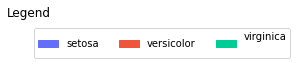

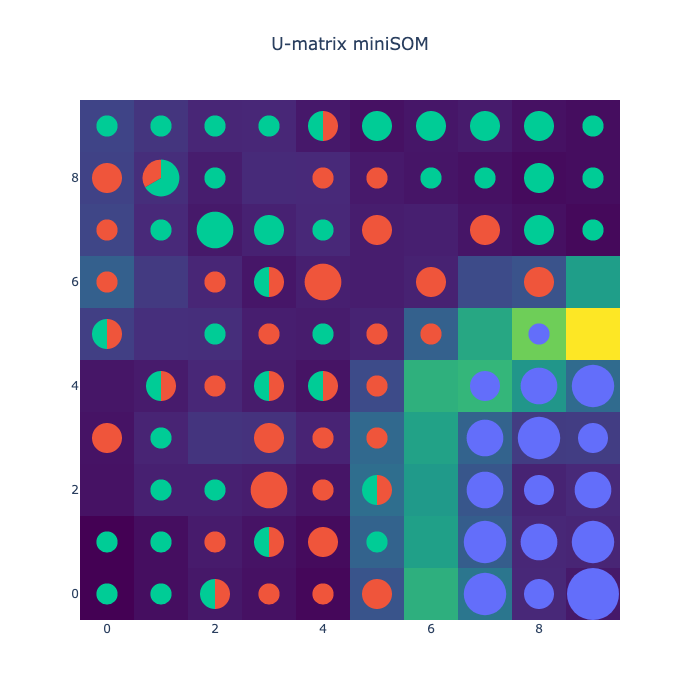

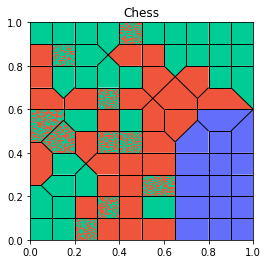

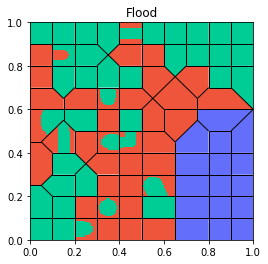

In [66]:
m=10
n=10

# Pre-processing
ogvalues = SOMToolBox_Parse('iris.vec')
idata, idim, idata_x, idata_y = ogvalues.read_weight_file()
scaled = min_max_scaler.fit_transform(idata)

# Train
s = som.MiniSom(m, n, scaled.shape[1], sigma=0.8, learning_rate=0.7)
s.train_random(scaled, 10000, verbose=False)

classmap = SOMToolBox_Parse('iris.cls')
cdata, cdata_x, cdata_y, cnum, cnam = classmap.read_class_file()
# Visualizaton
viz_miniSOM = SomViz(s._weights.reshape(-1,4), m, n)
um = viz_miniSOM.umatrix(color='viridis', interp=False, title='U-matrix miniSOM')
viz_miniSOM.addclasses(cdata=cdata.values, idata=scaled, cnum=cnum, cnam=cnam)

viz_miniSOM.show_legend()
viz_miniSOM.piecharts(som_m=um, scale=True)

viz_miniSOM.compute_voronoi()
viz_miniSOM.chess()
viz_miniSOM.flood()

# Visualizations
In this section of the notebook we look at visualizations created by our added visualization functions. First, we investigate the pie-chart, chessboard and attractor flooding visualizations on SOMs trained with the MiniSom library. More precisely we focus on SOMs of the size 40x20 and 100x60 in the first part of the analysis. In the second part, we consider maps that were pre-trained with the SOMToolbox and apply our visualization functions on them. Moreover, we compare them with visualizations created on the same maps by the SOMToolbox.

## Chainlink Dataset 40x20 (MiniSom)
In the following we show three visualizations. The first one is the pie-chart, the second one is the chessboard and the last one is the attractor flooding visualization. The maps they were built on were all created with MiniSom on the Chainlink dataset and the size of the SOM is 40x20. 

The legend shows that we have two classes and the color for the first class is blue and the color of the second class is red.

Now, we focus on the **pie-chart** visualization. The fact that each pie has only a single color shows that each unit only has instances of one class.

We added a scale parameter, which determines the sizes of the pies according to the number of instances that belong to an unit, to our pie-chart function. In the plot below it can be clearly seen that this scale parameter was set to true.

Moreover, we can add the piechart visualization on top of an already existing visualization. We also made use of that by plotting the pie-charts on a U-Matrix visualization in the image below. The U-Matrix shows the interpolated distances between the neighboring units. One can see that the distance gets larger when we see a change of class color, which makes sense and is the goal of such a visualization.

Next, we discuss the chainlink **chessboard** and the **attractor flooding** visualizations. Since there is always only one class per unit, the chessboard and attractor flooding visualizations are actually identical. Since this property holds for every map size on the Chainlink and 10Cluster dataset, we will later additionally observe the Boston-Housing and the Iris dataset to see our chessboard and attractor flooding visualizations in real action.

One can clearly retrieve the information where the blue class is dominant and where the red class is. In contrast to the U-Matrix the change of classes happens on the border of the polygons of the voronoi tessellation and the colors change immediatelly.

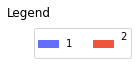

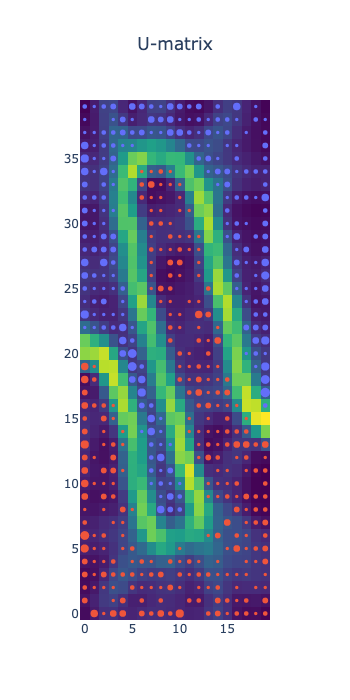

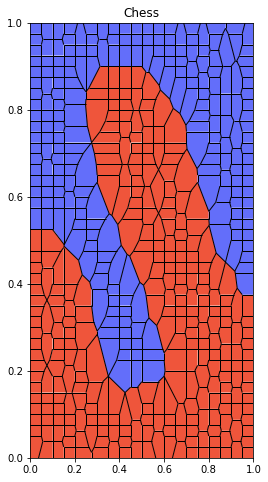

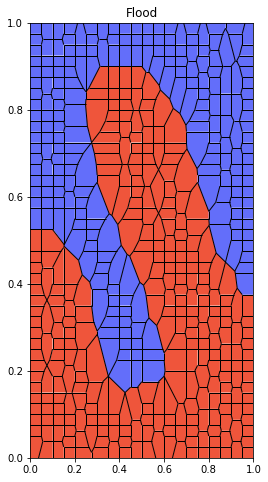

In [67]:
display(Image(filename='som_vis_files_final/chainlink_40_20_minisom_legend.png'))
display(Image(filename='som_vis_files_final/chainlink_40_20_minisom_pie.png'))
display(Image(filename='som_vis_files_final/chainlink_40_20_minisom_chess.png'))
display(Image(filename='som_vis_files_final/chainlink_40_20_minisom_flood.png'))

## Chainlink Dataset 100x60 (MiniSom)
In this section, we again discuss the same three visualizations on the Chainlink dataset. But this time we investigate whether our visualizations also work on a larger map. The map was also created by MiniSom.

Similarly, the legend shows that we have two classes and the color for the first class is blue and the color of the second class is red.

Only a quick glance suffices to see that the larger SOM is very similar to the smaller one from the section before. Additionally, also the visualizations work as expected. 

Obviously, due to the larger size of the SOM some details can be seen better. First, one can see in the pie-chart visualization that there are units that do not contain any instances. And secondly, it is easier to see the different sizes of the pies. But in terms of the correctness of the visualizations everything is fine.

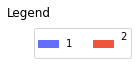

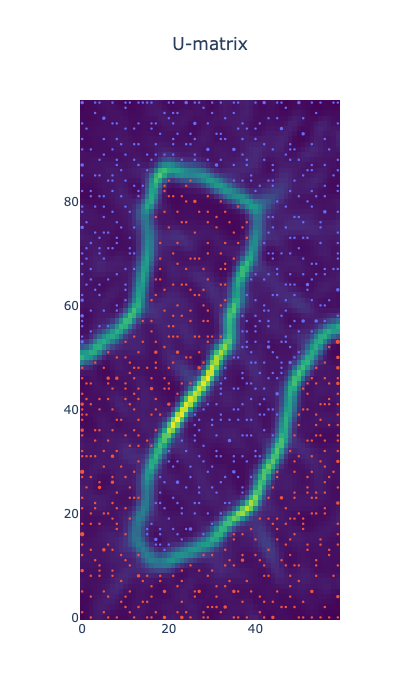

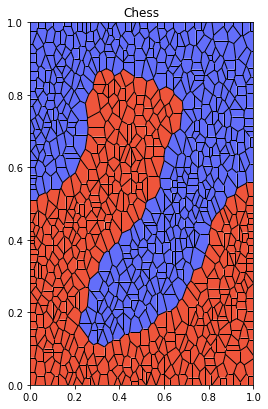

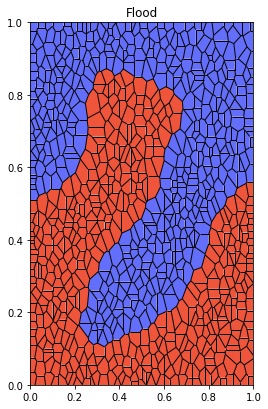

In [68]:
display(Image(filename='som_vis_files_final/chainlink_100_60_minisom_legend.png'))
display(Image(filename='som_vis_files_final/chainlink_100_60_minisom_pie.png'))
display(Image(filename='som_vis_files_final/chainlink_100_60_minisom_chess.png'))
display(Image(filename='som_vis_files_final/chainlink_100_60_minisom_flood.png'))

## 10Clusters Dataset 40x20 (MiniSom)
We continue with the same approach in exploring visualizations. However, the 10Clusters dataset contains ten different classes. Hence, the legend is accordingly.

Again, lets consider the **pie-chart** visualizations first. We can see that it works as expected also with more than two classes. It can be noticed that the underlying U-Matrix does not detect all of the cluster boarders. With the help of the pie-charts, however, the viewers can estimate themselves where there should be a border between clusters.

Regarding the **chessboard** and **attractor flooding** visualizations, we only can say again that they work for more than two classes as well. The clusters are at the expected locations and we again do not have any unit which contains more than to classes. But we will see later how our visualization functions react to this case.

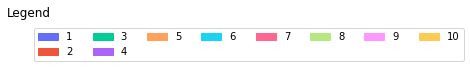

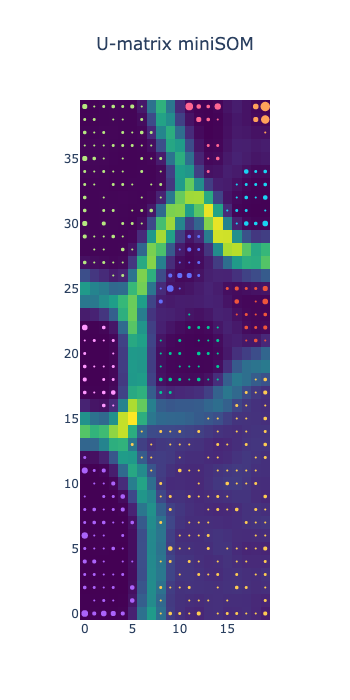

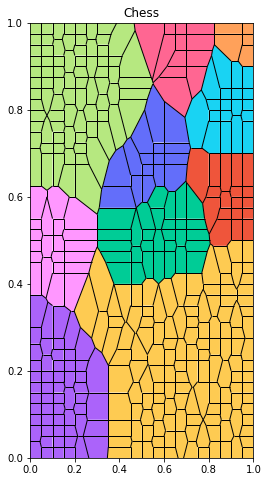

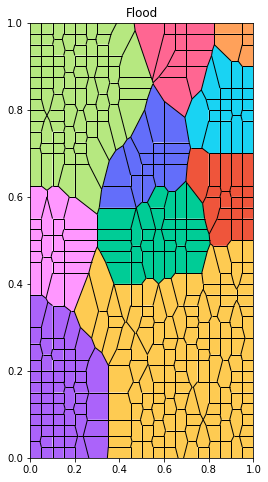

In [69]:
display(Image(filename='som_vis_files_final/10cluster_40_20_minisom_legend.png'))
display(Image(filename='som_vis_files_final/10cluster_40_20_minisom_pie.png'))
display(Image(filename='som_vis_files_final/10cluster_40_20_minisom_chess.png'))
display(Image(filename='som_vis_files_final/10cluster_40_20_minisom_flood.png'))

## 10Clusters Dataset 100x60 (MiniSom)
Finally, we come to the last plots of the initial investigation. Here we show the 10Cluster visualizations with SOMs of size 100x60 trained by MiniSom.

On the larger SOM the **pie-chart** visualization helps to show that there are less instances per unit than we have seen with the SOM of size 40x20. This can be seen due to the activation of the scale parameter and therefore the sizes of the pies.

There is not much to say about the **chessboard** and the **attractor flooding** visualizations. Everything works as expected given that each unit only contains instances of one class. In the next section we will see how our visualizations work if this is not the case anymore.

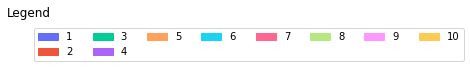

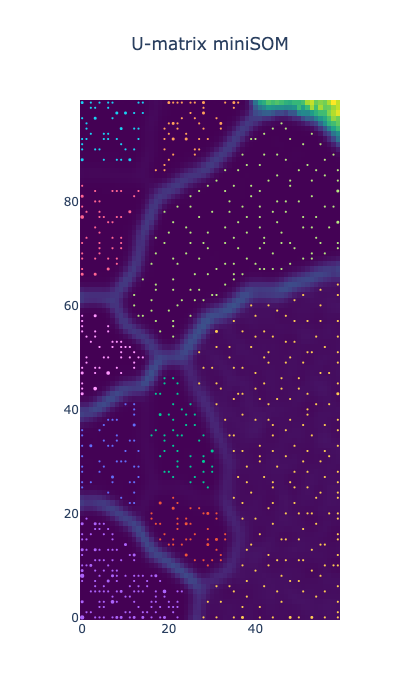

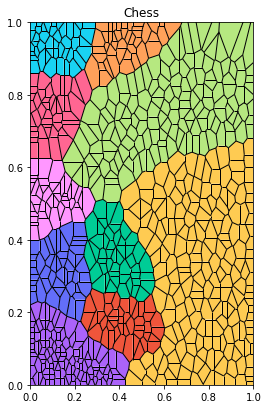

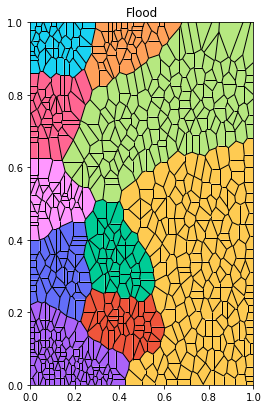

In [70]:
display(Image(filename='som_vis_files_final/10cluster_100_60_minisom_legend.png'))
display(Image(filename='som_vis_files_final/10cluster_100_60_minisom_pie.png'))
display(Image(filename='som_vis_files_final/10cluster_100_60_minisom_chess.png'))
display(Image(filename='som_vis_files_final/10cluster_100_60_minisom_flood.png'))

# Comparing our Functions with SOMToolBox
In this section we compare the visualizations genereted by SOMToolBox with the ones created by our functions. In order to get a good and fair comparison we use the same maps for both, our functions and the SOMToolBox. The pre-trained maps can be found under http://www.ifs.tuwien.ac.at/dm/somtoolbox/datasets.html.

In the following we will consider different datasets and compare each of the three visualizations for both methods.

### 10Clusters Pie-Chart Comparison
The first plot is the one created with our functions and the second one with the functions of the SOMToolbox. We have to be careful in this comparison since the color palettes are different for both visualizations. The colors of the U-Matrix differ and the colors for the classes are also different. The bright orange cluster in our visualization, e.g., is equivalent to the dark blue cluster in the SOMToolbox visualization.

Focussing on the pie-charts on both plots, we can confirm that our visualization is correct. Not only the large pies are equal but also the very small pies correspond to each other. Consider the small bright orange point in the middle of the orange cluster, the small violet and the small dark blue point in our visualization. All of them have their corresponding pie in the plot of the SOMToolbox (small dark blue point, small yellow point, small red point).

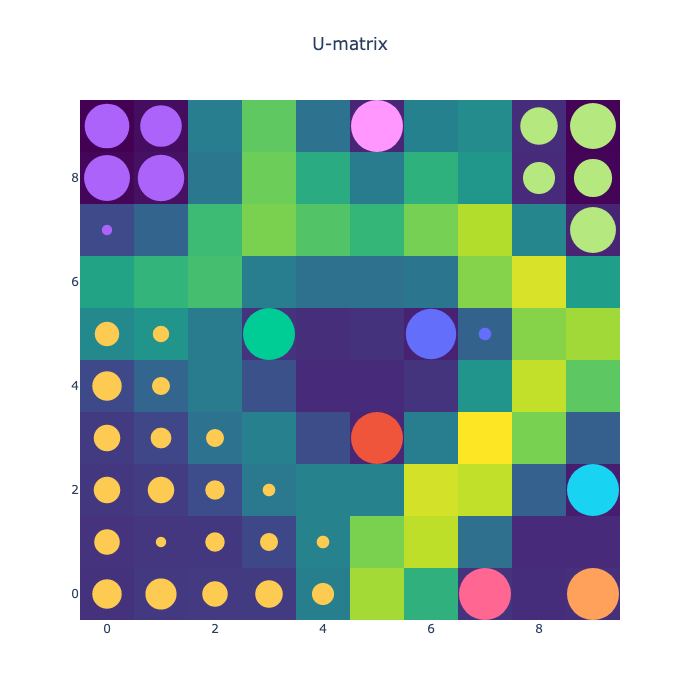

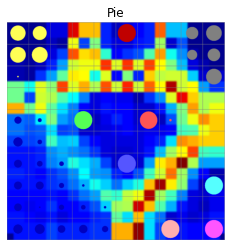

In [71]:
display(Image(filename='som_vis_files_final/10cluster_comparison_pie.png'))
display(Image(filename='som_vis_files_final/10cluster_comparison_toolbox_pie.png'))

### 10Clusters Chessboard and Attractor Flooding Comparison
Since we do not have units which contain mutliple classes, we only need one visualization for the comparison of the chessboard and attractor flooding visualizations between our and the SOMToolbox visualization.

We have to be careful with the colors again. But apart from the colors, the visualizations are the same.

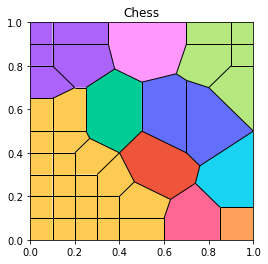

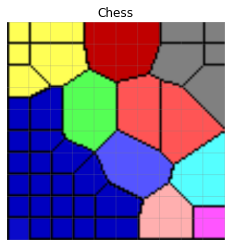

In [72]:
display(Image(filename='som_vis_files_final/10cluster_comparison_chess.png'))
display(Image(filename='som_vis_files_final/10cluster_comparison_toolbox_chess.png'))


### Chainlink Pie-Chart Comparison
Once more our visualization is shown first and we keep it this way in further comparisons. So, we do not have to mention this anymore from now on.

In this comparison the colors of the classes are mixed up. The red class in our visualization corresponds to the blue class in the visualilzation of the SOMToolBox. The U-Matrix of the SOMToolBox seems a little more sophisticated and detailed than the U-Matrix of our visualization. However, this is not part of our implementation. Considering the pie-charts one can see that they are equivalent (considering the color swap) once more.

Again, lets consider the **pie-chart** visualizations first. We can see that it works as expected also with more than two classes. It can be noticed that the underlying U-Matrix does not detect all of the cluster boarders. With the help of the pie-charts, however, the viewers can estimate themselves where there should be a border between clusters.

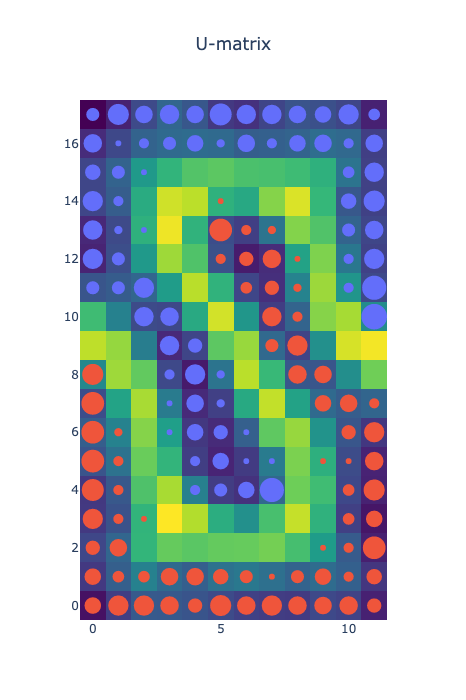

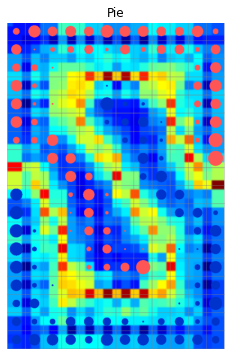

In [73]:
display(Image(filename='som_vis_files_final/chainlink_comparison_pie.png'))
display(Image(filename='som_vis_files_final/chainlink_comparison_toolbox_pie.png'))

### Chainlink Chessboard and Attractor Flooding Comparison

Regarding the **chessboard** and **attractor flooding** visualizations, we only can say again that they work for more than two classes as well. The clusters are at the expected locations and we again do not have any unit which contains more than to classes. But we will see later how our visualization functions react to this case.

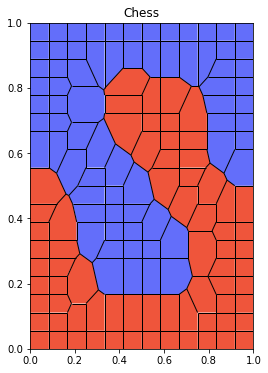

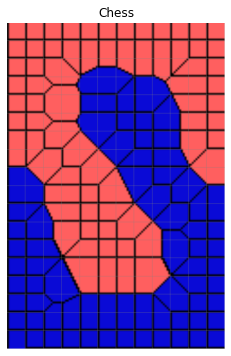

In [74]:
display(Image(filename='som_vis_files_final/chainlink_comparison_chess.png'))
display(Image(filename='som_vis_files_final/chainlink_comparison_toolbox_chess.png'))


### Boston Housing Pie-Chart Comparison

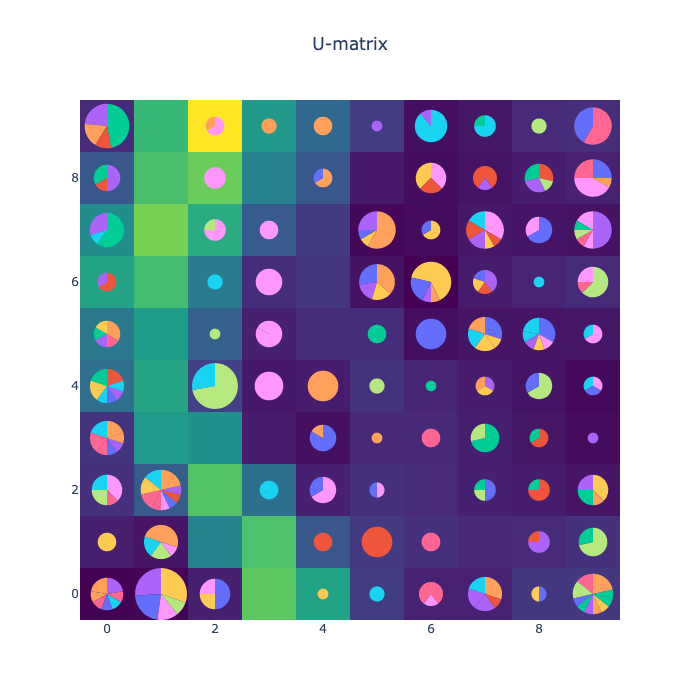

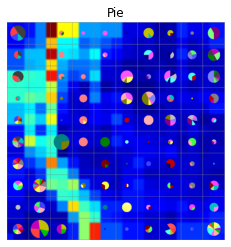

In [75]:
display(Image(filename='som_vis_files_final/boston_comparison_pie.png'))
display(Image(filename='som_vis_files_final/boston_comparison_toolbox_pie.png'))

### Chainlink Chessboard Comparison

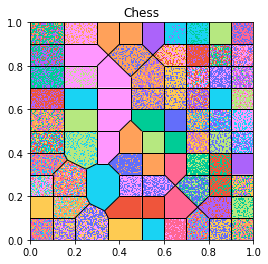

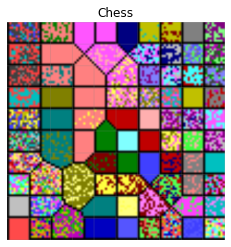

In [76]:
display(Image(filename='som_vis_files_final/boston_comparison_chess.png'))
display(Image(filename='som_vis_files_final/boston_comparison_toolbox_chess.png'))

### Chainlink Chessboard Comparison

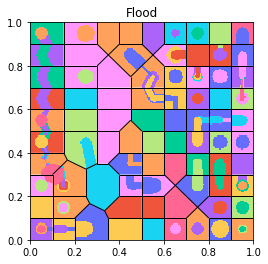

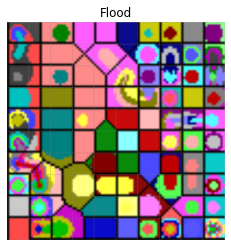

In [77]:
display(Image(filename='som_vis_files_final/boston_comparison_flood.png'))
display(Image(filename='som_vis_files_final/boston_comparison_toolbox_flood.png'))
